In [6]:
"""
Avellaneda-Stoikov style market making (discrete approximation)

Class AvellanedaMM:
- update_market(mid_price, timestamp)
- quote() -> (bid_price, bid_size, ask_price, ask_size)
- on_trade(side, size, price)  # inform the MM it got filled
- step(dt)  # optional time step for decay / horizon

Example usage at bottom.
"""

import math
import time

class AvellanedaMM:
    def __init__(self,
                 gamma=0.1,        # risk aversion
                 sigma=0.02,       # (annualized) volatility estimate (in price units)
                 k=1.5,            # order arrival sensitivity (higher -> more passive spreads)
                 A=140.0,          # base intensity (liquidity) parameter
                 inventory_limit=10,
                 position_size=1,
                 horizon=1.0        # time horizon (in same time units as sigma) used in formula
                 ):
        """
        Parameters:
          gamma: risk aversion (higher -> quotes closer to mid but smaller inventory exposure)
          sigma: volatility (annualized or consistent time unit)
          k, A: intensity parameters for exponential fill probability model:
                lambda(delta) = A * exp(-k * delta)
          inventory_limit: max absolute inventory allowed
          position_size: default order size quoted on each side
          horizon: time horizon remaining (used for reservation price & spread)
        """
        self.gamma = gamma
        self.sigma = sigma
        self.k = k
        self.A = A
        self.inventory_limit = inventory_limit
        self.position_size = position_size
        self.horizon = horizon

        # state
        self.mid = None
        self.t = 0.0  # current time (arbitrary units)
        self.inventory = 0.0
        self.cash = 0.0
        self.pnl = 0.0
        self.history = []  # store quotes / trades for analysis

    # ---- core model formulas (Avellaneda-Stoikov discrete form) ----
    def reservation_price(self):
        """
        Reservation price r_t = S_t - q_t * gamma * sigma^2 * (T - t)
        (S_t = mid price)
        """
        if self.mid is None:
            raise RuntimeError("mid price unknown")
        return self.mid - self.inventory * self.gamma * (self.sigma ** 2) * self.horizon

    def optimal_half_spread(self):
        """
        A commonly used closed form for optimal half spread (delta*):
          delta* = (gamma * sigma^2 * horizon / 2) + (1/gamma) * ln(1 + gamma/k)
        This is the discrete-approx form used in many implementations.
        Note: different papers/implementations use slightly different constant terms.
        """
        term1 = 0.5 * self.gamma * (self.sigma ** 2) * self.horizon
        # ensure k non-zero
        if self.k <= 0:
            term2 = 0.0
        else:
            # avoid negative/zero inside log
            term2 = (1.0 / self.gamma) * math.log(1.0 + self.gamma / self.k)
        return term1 + term2

    # ---- public API ----
    def update_market(self, mid_price, timestamp=None):
        """Update the mid (market) price and optional time"""
        self.mid = float(mid_price)
        if timestamp is not None:
            self.t = float(timestamp)

    def quote(self):
        """
        Return (bid_price, bid_size, ask_price, ask_size).
        We clip inventory to inventory_limit by shifting quotes or disabling one side.
        """
        r = self.reservation_price()
        half_spread = self.optimal_half_spread()

        bid = r - half_spread
        ask = r + half_spread

        # inventory control: if inventory too long, skew quotes to encourage sells (wider ask / tighter bid)
        # simple rule: if inventory > 0, move both quotes down by alpha*inventory
        inventory_skew = 0.0
        alpha = 0.02  # tuning parameter: how aggressively to skew per unit inventory
        inventory_skew = alpha * self.inventory

        bid -= inventory_skew
        ask -= inventory_skew

        # limit inventories: if beyond limit, disable the side that increases exposure
        bid_size = self.position_size
        ask_size = self.position_size
        if self.inventory >= self.inventory_limit:
            # too long, don't post bids
            bid = None
            bid_size = 0
        if self.inventory <= -self.inventory_limit:
            # too short, don't post asks
            ask = None
            ask_size = 0

        # record quote for debugging / analysis
        self.history.append({
            'time': self.t,
            'mid': self.mid,
            'inventory': self.inventory,
            'reservation': r,
            'half_spread': half_spread,
            'bid': bid,
            'ask': ask
        })

        return bid, bid_size, ask, ask_size

    def on_trade(self, side, size, price):
        """
        Inform the MM that an order executed.
        side: 'buy' or 'sell' from MM's perspective:
          - 'buy' means MM bought (so inventory increases)
          - 'sell' means MM sold (inventory decreases)
        price: execution price
        size: executed size
        """
        if side not in ('buy', 'sell'):
            raise ValueError("side must be 'buy' or 'sell'")

        if side == 'buy':
            self.inventory += size
            self.cash -= price * size
        else:
            self.inventory -= size
            self.cash += price * size

        # update P&L mark-to-market
        if self.mid is not None:
            self.pnl = self.cash + self.inventory * self.mid

        self.history.append({
            'time': self.t,
            'trade': {'side': side, 'size': size, 'price': price},
            'inventory': self.inventory,
            'cash': self.cash,
            'pnl': self.pnl
        })

    def step(self, dt):
        """Advance time horizon (simple): reduce horizon by dt"""
        self.horizon = max(0.0, self.horizon - dt)
        self.t += dt

    # utility for diagnostics
    def snapshot(self):
        return {
            'time': self.t,
            'mid': self.mid,
            'inventory': self.inventory,
            'cash': self.cash,
            'pnl': self.pnl,
            'horizon': self.horizon
        }

# ---------------------------
# Example simple simulation
# ---------------------------
if __name__ == "__main__":
    import random

    mm = AvellanedaMM(gamma=0.1, sigma=0.02, k=1.2, A=120.0, inventory_limit=5, position_size=1, horizon=1.0)
    mm.update_market(mid_price=100.0, timestamp=0.0)

    # naive simulation: at each step, we get a mid price move and sample fills probabilistically:
    for i in range(200):
        # small mid price random walk
        mid_move = random.gauss(0, mm.sigma * math.sqrt(1/252/24/60))  # example small step (very rough)
        new_mid = mm.mid + mid_move
        mm.update_market(new_mid, timestamp=i * 0.01)

        bid, bid_size, ask, ask_size = mm.quote()

        # simulate fill probabilities using lambda(delta) = A * exp(-k * delta)
        # if quote is None (disabled), no fills.
        if bid is not None:
            delta_bid = max(0.0001, mm.mid - bid)
            lambda_bid = mm.A * math.exp(-mm.k * delta_bid)
            # Poisson approx: prob of at least one fill in dt ~ 1 - exp(-lambda * dt)
            prob_fill_bid = 1.0 - math.exp(-lambda_bid * 0.01)
            if random.random() < prob_fill_bid:
                mm.on_trade('buy', bid_size, bid)

        if ask is not None:
            delta_ask = max(0.0001, ask - mm.mid)
            lambda_ask = mm.A * math.exp(-mm.k * delta_ask)
            prob_fill_ask = 1.0 - math.exp(-lambda_ask * 0.01)
            if random.random() < prob_fill_ask:
                mm.on_trade('sell', ask_size, ask)

        mm.step(0.01)

    print("Final snapshot:", mm.snapshot())
    # you can inspect mm.history for analysis


Final snapshot: {'time': 2.0, 'mid': 99.99980990270959, 'inventory': 3.0, 'cash': -188.01942855893506, 'pnl': 111.980441405466, 'horizon': 0.0}


prob_fill_bid:0.3682269367655586
prob_fill_ask:0.3682269367655586
prob_fill_bid:0.37524906597450847
prob_fill_ask:0.3612956668726578
prob_fill_bid:0.3752489954423036
prob_fill_ask:0.3612958730373961
prob_fill_bid:0.37524892491010287
prob_fill_ask:0.36129607920222095
prob_fill_bid:0.375248854377911
prob_fill_ask:0.3612962853671279
prob_fill_bid:0.375248783845728
prob_fill_ask:0.36129649153210686
prob_fill_bid:0.37524871331355414
prob_fill_ask:0.36129669769717754
prob_fill_bid:0.37524864278138914
prob_fill_ask:0.36129690386232993
prob_fill_bid:0.37524857224923813
prob_fill_ask:0.3612971100275596
prob_fill_bid:0.3752485017170911
prob_fill_ask:0.361297316192876
prob_fill_bid:0.3752484311849531
prob_fill_ask:0.36129752235827406
prob_fill_bid:0.3823589782583675
prob_fill_ask:0.354459060843329
prob_fill_bid:0.38955836483519624
prob_fill_ask:0.3477126927708124
prob_fill_bid:0.3968456427540459
prob_fill_ask:0.341058837685147
prob_fill_bid:0.4042197520196602
prob_fill_bid:0.39684461814283234
pro

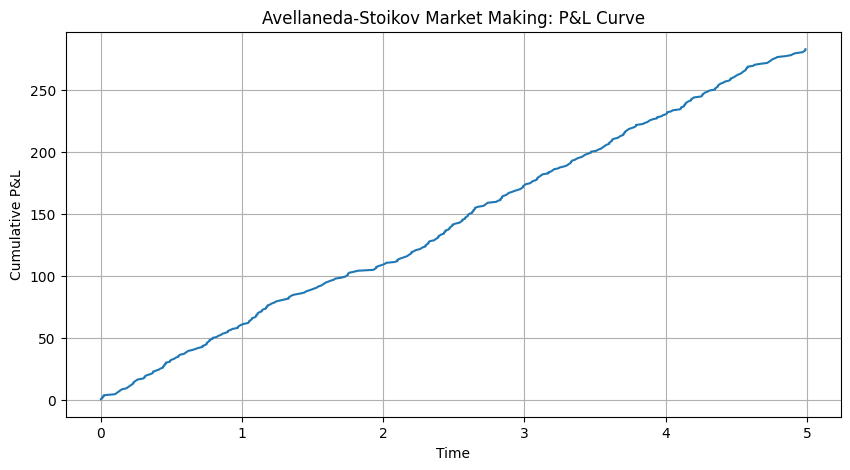

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math, random

# --- 複製之前的 AvellanedaMM class 定義（省略此處以節省篇幅） ---
# 假設你已經定義過上面的 AvellanedaMM 類別

# 初始化做市模型
mm = AvellanedaMM(gamma=0.1, sigma=0.02, k=1.2, A=120.0,
                  inventory_limit=5, position_size=1, horizon=1.0)
mm.update_market(mid_price=100.0, timestamp=0.0)

# 模擬市場與做市過程
for i in range(500):  # 多跑一點步數讓曲線更平滑
    mid_move = random.gauss(0, mm.sigma * math.sqrt(1/252/24/60))
    new_mid = mm.mid + mid_move
    mm.update_market(new_mid, timestamp=i * 0.01)

    bid, bid_size, ask, ask_size = mm.quote()

    if bid is not None:
        delta_bid = max(0.0001, mm.mid - bid)
        lambda_bid = mm.A * math.exp(-mm.k * delta_bid)
        prob_fill_bid = 1.0 - math.exp(-lambda_bid * 0.01)
        print(f"prob_fill_bid:{prob_fill_bid}")
        if random.random() < prob_fill_bid:
            mm.on_trade('buy', bid_size, bid)

    if ask is not None:
        delta_ask = max(0.0001, ask - mm.mid)
        lambda_ask = mm.A * math.exp(-mm.k * delta_ask)
        prob_fill_ask = 1.0 - math.exp(-lambda_ask * 0.01)
        print(f"prob_fill_ask:{prob_fill_ask}")
        if random.random() < prob_fill_ask:
            mm.on_trade('sell', ask_size, ask)

    mm.step(0.01)

# --- 轉成 DataFrame 繪圖 ---
df = pd.DataFrame(mm.history)
# 取出有 pnl 欄位的紀錄
df_pnl = df.dropna(subset=["pnl"])

plt.figure(figsize=(10,5))
plt.plot(df_pnl["time"], df_pnl["pnl"], lw=1.5)
plt.title("Avellaneda-Stoikov Market Making: P&L Curve")
plt.xlabel("Time")
plt.ylabel("Cumulative P&L")
plt.grid(True)
plt.show()

# gateio數據報酬曲線

Calibrated A = 0.40659406003552573
delta_bid 0.8004470767336898 lambda 0.4592250264805381 p 0.3682269367661424
delta_ask 0.8004470767336898 lambda 0.4592250264805381 p 0.3682269367661424
delta_bid 0.800427076741471 lambda 0.45923604800914347 p 0.368233899832659
delta_ask 0.800427076741471 lambda 0.45923604800914347 p 0.368233899832659
delta_bid 0.7804270767373964 lambda 0.47039103760441825 p 0.37524208332859643
delta_ask 0.8204270767455455 lambda 0.44834559107483174 p 0.3613160775757356
delta_bid 0.7804270767373964 lambda 0.47039103760441825 p 0.37524208332859643
delta_ask 0.8204270767455455 lambda 0.44834559107483174 p 0.3613160775757356
delta_bid 0.800427076741471 lambda 0.45923604800914347 p 0.368233899832659
delta_ask 0.800427076741471 lambda 0.45923604800914347 p 0.368233899832659
delta_bid 0.800427076741471 lambda 0.45923604800914347 p 0.368233899832659
delta_ask 0.800427076741471 lambda 0.45923604800914347 p 0.368233899832659
delta_bid 0.800427076741471 lambda 0.4592360480091434

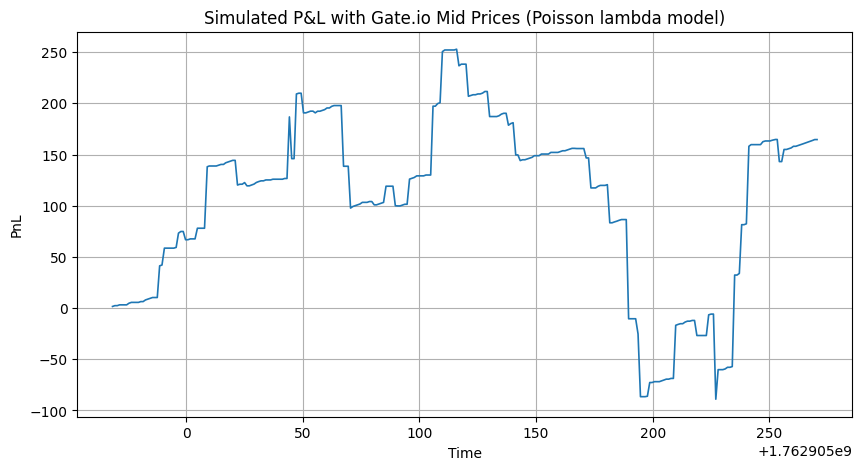

In [3]:
import time, math, random
import pandas as pd
import matplotlib.pyplot as plt
from gate_api import ApiClient, Configuration, SpotApi

# 假設 AvellanedaMM 已在同一檔案或已 import

# ---------- calibration helper ----------
def calibrate_A(desired_prob_at_delta, delta_ref, k, dt):
    """
    Solve for A given desired probability at delta_ref:
      desired_prob = 1 - exp(- A * exp(-k * delta_ref) * dt)
    => A = -ln(1 - desired_prob) / (exp(-k * delta_ref) * dt)
    """
    if not (0 < desired_prob_at_delta < 1):
        raise ValueError("desired_prob_at_delta must be in (0,1)")
    denom = math.exp(-k * delta_ref) * dt
    if denom <= 0:
        raise ValueError("invalid denom for calibration")
    A = -math.log(1.0 - desired_prob_at_delta) / denom
    return A

# ---------- Gate.io client (行情用) ----------
config = Configuration(host="https://api.gateio.ws/api/v4")
client = SpotApi(ApiClient(config))
symbol = "BTC_USDT"

# ---------- 模擬參數（可調） ----------
dt = 1.0                   # 每步時間（秒） - 與 A 一起決定 lambda*dt
k = 1.2                    # 保留原 k（若 delta 很小，k 可調）
# 選一個參考距離 delta_ref 與希望的參考機率 p0，安定地求出 A
# delta_ref 依你 delta 的定義（下例使用「絕對價格差」）
delta_ref = 0.5            # 例如「0.5 price unit」做為參考距離（按你商品價格量級調整）
p0 = 0.2                   # 希望在 delta_ref 的成交機率為 20%
A = calibrate_A(p0, delta_ref, k, dt)
print("Calibrated A =", A)

# 也可以直接手動設 A，例如 A = 1.0
A = 1.2

# ---------- 初始化 MM ----------
mm = AvellanedaMM(gamma=0.1, sigma=0.02, k=k, A=A,
                  inventory_limit=5, position_size=1, horizon=1.0)

# 讀取初始 mid
ticker0 = client.list_tickers(currency_pair=symbol)[0]
bid0 = float(ticker0.highest_bid)
ask0 = float(ticker0.lowest_ask)
mid0 = (bid0 + ask0) / 2.0
mm.update_market(mid_price=mid0, timestamp=time.time())

# ---------- 模擬 loop ----------
n_steps = 300
results = []

for i in range(n_steps):
    try:
        t0 = time.time()
        ticker = client.list_tickers(currency_pair=symbol)[0]
        bid_m = float(ticker.highest_bid)
        ask_m = float(ticker.lowest_ask)
        mid = (bid_m + ask_m) / 2.0

        mm.update_market(mid_price=mid, timestamp=time.time())
        bid_price, bid_size, ask_price, ask_size = mm.quote()

        # 注意：在原公式中 delta 是「價格差」，確保你使用和 k/校準相同的 delta 定義
        # 模擬成交：bid side
        if bid_price is not None:
            delta_bid = max(1e-9, mm.mid - bid_price)   # 絕對價差（price units）
            lambda_bid = mm.A * math.exp(-mm.k * delta_bid)
            prob_fill_bid = 1.0 - math.exp(-lambda_bid * dt)
            prob_fill_bid = min(max(prob_fill_bid, 0.0), 1.0)  # clip for safety
            # debug
            print("delta_bid", delta_bid, "lambda", lambda_bid, "p", prob_fill_bid)
            if random.random() < prob_fill_bid:
                mm.on_trade('buy', bid_size, bid_price)

        # 模擬成交：ask side
        if ask_price is not None:
            delta_ask = max(1e-9, ask_price - mm.mid)
            lambda_ask = mm.A * math.exp(-mm.k * delta_ask)
            prob_fill_ask = 1.0 - math.exp(-lambda_ask * dt)
            prob_fill_ask = min(max(prob_fill_ask, 0.0), 1.0)
            print("delta_ask", delta_ask, "lambda", lambda_ask, "p", prob_fill_ask)
            if random.random() < prob_fill_ask:
                mm.on_trade('sell', ask_size, ask_price)

        mm.step(dt)
        results.append(mm.snapshot())

        # 等待下一步（把每步耗時扣掉）
        elapsed = time.time() - t0
        sleep_for = max(0.0, dt - elapsed)
        time.sleep(sleep_for)

    except Exception as e:
        print("loop error:", e)
        time.sleep(1.0)

# ---------- 畫圖 ----------
df = pd.DataFrame(results)
plt.figure(figsize=(10,5))
plt.plot(df['time'], df['pnl'], lw=1.2)
plt.title("Simulated P&L with Gate.io Mid Prices (Poisson lambda model)")
plt.xlabel("Time")
plt.ylabel("PnL")
plt.grid(True)
plt.show()


# 真實下單版

In [13]:
import os
import time
import math
import random
import logging
from typing import Optional

import pandas as pd
import matplotlib.pyplot as plt

import gate_api
from gate_api import ApiClient, Configuration, SpotApi, Order
from dotenv import load_dotenv

load_dotenv()

# -------------------------
# Config / env
# -------------------------
TESTNET_BASE = "https://api-testnet.gateapi.io/api/v4"   # Gate.io Testnet base URL. (official doc)
# Put your Testnet API key/secret in environment variables
API_KEY = os.getenv('GATEIO_API_KEY')
API_SECRET = os.getenv('GATEIO_API_SECRET')
if not API_KEY or not API_SECRET:
    raise RuntimeError("Set GATE_TESTNET_KEY and GATE_TESTNET_SECRET environment variables (Testnet keys)")

SYMBOL = os.getenv("SYMBOL", "BTC_USDT")   # trading pair to test
DT = float(os.getenv("DT", "1.0"))         # seconds between decision loops
POSITION_SIZE = float(os.getenv("POSITION_SIZE", "0.0001"))  # tiny for testnet
MAX_OPEN_ORDERS_PER_SIDE = 1
INVENTORY_LIMIT = float(os.getenv("INVENTORY_LIMIT", "0.01"))  # small

# logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

# -------------------------
# Init Gate API client (Testnet)
# -------------------------
cfg = Configuration(host=TESTNET_BASE, key=API_KEY, secret=API_SECRET)
api_client = ApiClient(cfg)
spot_api = SpotApi(api_client)

# -------------------------
# Helper functions for execution
# -------------------------
def get_mid_from_ticker(symbol: str) -> float:
    """Use REST list_tickers to get best bid/ask and mid"""
    try:
        tickers = spot_api.list_tickers(currency_pair=symbol)
        if not tickers:
            raise RuntimeError("no ticker returned")
        t = tickers[0]
        bid = float(t.highest_bid)
        ask = float(t.lowest_ask)
        return (bid + ask) / 2.0
    except Exception as e:
        logging.exception("failed to fetch ticker")
        raise

def place_limit_order(symbol: str, side: str, price: float, amount: float):
    """
    Create a limit order via SDK.
    Returns created order object (SDK model) on success.
    """
    try:
        order = Order(currency_pair=symbol, type='limit', account='spot',
                      side=side, amount=str(amount), price=str(price))
        resp = spot_api.create_order(order=order)
        logging.info("Placed order: side=%s price=%s amount=%s id=%s", side, price, amount, getattr(resp, 'id', None))
        return resp
    except Exception as e:
        logging.exception("create_order failed")
        return None

def fetch_order_status(order_id: str, symbol: Optional[str] = None):
    """GET /spot/orders/{order_id} — return order object (or None)"""
    try:
        # Some SDK variants require currency_pair param; pass if needed
        return spot_api.get_order(order_id=order_id, currency_pair=symbol)
    except Exception as e:
        logging.debug("get_order failed for id=%s : %s", order_id, e)
        return None

def cancel_order(order_id: str, symbol: Optional[str] = None):
    try:
        spot_api.cancel_order(order_id=order_id, currency_pair=symbol)
        logging.info("Cancelled order %s", order_id)
    except Exception as e:
        logging.exception("cancel_order failed for %s", order_id)

def get_available_balance(currency="USDT"):
    """查詢目前可用餘額"""
    try:
        accounts = spot_api.list_spot_accounts()
        for a in accounts:
            if a.currency.upper() == currency.upper():
                return float(a.available)
        return 0.0
    except Exception as e:
        logging.exception("failed to fetch balance")
        return 0.0


def print_balances():
    """列印餘額狀況"""
    try:
        accounts = spot_api.list_spot_accounts()
        print("\n=== Account Balances ===")
        for a in accounts:
            total = float(a.available) + float(a.locked)
            if total > 0:
                print(f"{a.currency}: available={a.available}, locked={a.locked}")
        print("========================\n")
    except Exception as e:
        logging.exception("failed to fetch balances")


def print_open_orders(symbol):
    """列印當前未成交掛單"""
    try:
        orders = spot_api.list_orders(currency_pair=symbol, status="open")
        if not orders:
            print("\n(目前無 open orders)\n")
            return
        print("\n=== Open Orders ===")
        for o in orders:
            print(f"{o.side} {o.amount}@{o.price} (id={o.id})")
        print("====================\n")
    except Exception as e:
        logging.exception("failed to fetch open orders")


def main():
    mm = AvellanedaMM(gamma=0.1, sigma=0.02, k=1.2, A=1.0,
                      inventory_limit=INVENTORY_LIMIT, position_size=POSITION_SIZE, horizon=1.0)

    mid0 = get_mid_from_ticker(SYMBOL)
    mm.update_market(mid_price=mid0, timestamp=time.time())

    open_orders = {}

    n_steps = int(os.getenv("N_STEPS", "300"))
    for i in range(n_steps):
        loop_start = time.time()
        try:
            mid = get_mid_from_ticker(SYMBOL)
            mm.update_market(mid_price=mid, timestamp=time.time())
            bid_price, bid_size, ask_price, ask_size = mm.quote()

            # ---- 每 10 步打印一次餘額與掛單狀況 ----
            if i % 10 == 0:
                print_balances()
                print_open_orders(SYMBOL)

            # ---- inventory 風控 ----
            if mm.inventory >= mm.inventory_limit:
                logging.info("inventory >= limit; skipping bids")
                bid_price, bid_size = None, 0
            if mm.inventory <= -mm.inventory_limit:
                logging.info("inventory <= -limit; skipping asks")
                ask_price, ask_size = None, 0

            bids_open = sum(1 for v in open_orders.values() if v['side'] == 'buy')
            asks_open = sum(1 for v in open_orders.values() if v['side'] == 'sell')

            PRICE_EPS = 1e-8
            def exists_near(side, price):
                for o in open_orders.values():
                    if o['side'] == side and abs(float(o['price']) - price) <= PRICE_EPS:
                        return True
                return False

            # ---- 檢查可用餘額再掛單 ----
            available_usdt = get_available_balance("USDT")

            if bid_price is not None and bids_open < MAX_OPEN_ORDERS_PER_SIDE and not exists_near('buy', bid_price):
                cost_est = bid_size * bid_price
                if available_usdt >= cost_est:
                    resp = place_limit_order(SYMBOL, 'buy', price=round(bid_price, 8), amount=bid_size)
                    if resp and getattr(resp, 'id', None):
                        open_orders[str(resp.id)] = {'side': 'buy', 'price': float(resp.price), 'amount': float(resp.amount)}
                    time.sleep(0.3)
                else:
                    logging.warning("Insufficient USDT to place buy order (need %.4f, have %.4f)", cost_est, available_usdt)

            if ask_price is not None and asks_open < MAX_OPEN_ORDERS_PER_SIDE and not exists_near('sell', ask_price):
                resp = place_limit_order(SYMBOL, 'sell', price=round(ask_price, 8), amount=ask_size)
                if resp and getattr(resp, 'id', None):
                    open_orders[str(resp.id)] = {'side': 'sell', 'price': float(resp.price), 'amount': float(resp.amount)}
                time.sleep(0.3)

            # ---- 更新已成交訂單 ----
            to_remove = []
            for oid, meta in list(open_orders.items()):
                o = fetch_order_status(order_id=oid, symbol=SYMBOL)
                if o is None:
                    continue
                status = getattr(o, 'status', None)
                filled = float(getattr(o, 'filled_amount', 0) or 0)
                total = float(getattr(o, 'amount', meta['amount']) or meta['amount'])
                if filled > 0:
                    side = meta['side']
                    price = float(getattr(o, 'price', meta['price']))
                    mm.on_trade(side, filled, price)
                    logging.info("Order %s filled: side=%s filled=%s price=%s", oid, side, filled, price)
                if status in ('closed', 'cancelled', 'finished', 'finished_partially') or abs(filled - total) < 1e-12:
                    to_remove.append(oid)

            for oid in to_remove:
                open_orders.pop(oid, None)

            mm.step(DT)
            time.sleep(max(0.0, DT - (time.time() - loop_start)))

        except Exception as e:
            logging.exception("main loop error")
            time.sleep(1.0)

    # ---- 結束前取消所有掛單 ----
    for oid in list(open_orders.keys()):
        cancel_order(oid, SYMBOL)
        time.sleep(0.1)

    # ---- 畫報酬曲線 ----
    df = pd.DataFrame(mm.history)
    df_pnl = df.dropna(subset=['pnl'])
    if not df_pnl.empty:
        plt.figure(figsize=(10, 5))
        plt.plot(df_pnl['time'], df_pnl['pnl'])
        plt.title("Testnet Live PnL")
        plt.xlabel("time")
        plt.ylabel("PnL")
        plt.grid(True)
        plt.show()
    else:
        logging.info("No pnl data to plot.")


if __name__ == "__main__":
    print_balances()
    main()



=== Account Balances ===
BTC: available=0.0006992, locked=0.0001
USDT: available=917.48178, locked=0


=== Account Balances ===
BTC: available=0.0006992, locked=0.0001
USDT: available=917.48178, locked=0


=== Open Orders ===
sell 0.0001@103127.1 (id=207248842)



2025-11-12 08:27:54,774 INFO Placed order: side=buy price=103102.34955292 amount=0.0001 id=207250641
2025-11-12 08:27:55,137 INFO Placed order: side=sell price=103103.95044708 amount=0.0001 id=207250649
2025-11-12 08:28:01,799 INFO Order 207250641 filled: side=buy filled=0.0001 price=103102.3
2025-11-12 08:28:02,800 INFO Placed order: side=buy price=103102.34957092 amount=0.0001 id=207250784
2025-11-12 08:28:03,196 INFO Order 207250784 filled: side=buy filled=0.0001 price=103102.3
2025-11-12 08:28:03,789 INFO Placed order: side=buy price=103102.34956892 amount=0.0001 id=207250799
2025-11-12 08:28:04,175 INFO Order 207250799 filled: side=buy filled=0.0001 price=103102.3
2025-11-12 08:28:04,884 INFO Placed order: side=buy price=103102.34956692 amount=0.0001 id=207250833



=== Account Balances ===
BTC: available=0.0008989, locked=0.0002
USDT: available=886.55645, locked=0


=== Open Orders ===
sell 0.0001@103104 (id=207250649)
sell 0.0001@103127.1 (id=207248842)



2025-11-12 08:28:05,281 INFO Order 207250833 filled: side=buy filled=0.0001 price=103102.3
2025-11-12 08:28:05,810 INFO Placed order: side=buy price=103066.64956492 amount=0.0001 id=207250840
2025-11-12 08:28:08,880 INFO Order 207250840 filled: side=buy filled=0.0001 price=103066.6
2025-11-12 08:28:09,866 INFO Placed order: side=buy price=103066.64956292 amount=0.0001 id=207250938
2025-11-12 08:28:11,932 INFO Order 207250938 filled: side=buy filled=0.0001 price=103066.6
2025-11-12 08:28:12,886 INFO Placed order: side=buy price=103066.64956092 amount=0.0001 id=207250992
2025-11-12 08:28:13,277 INFO Order 207250992 filled: side=buy filled=0.0001 price=103066.6
2025-11-12 08:28:13,900 INFO Placed order: side=buy price=103066.64955892 amount=0.0001 id=207251014
2025-11-12 08:28:14,292 INFO Order 207251014 filled: side=buy filled=0.0001 price=103066.6
2025-11-12 08:28:15,002 INFO Placed order: side=buy price=103066.64955692 amount=0.0001 id=207251029



=== Account Balances ===
BTC: available=0.0013984, locked=0.0002
USDT: available=835.02254, locked=0


=== Open Orders ===
sell 0.0001@103104 (id=207250649)
sell 0.0001@103127.1 (id=207248842)



2025-11-12 08:28:15,397 INFO Order 207251029 filled: side=buy filled=0.0001 price=103066.6
2025-11-12 08:28:15,926 INFO Placed order: side=buy price=103066.64955492 amount=0.0001 id=207251041
2025-11-12 08:28:16,323 INFO Order 207251041 filled: side=buy filled=0.0001 price=103066.6
2025-11-12 08:28:16,926 INFO Placed order: side=buy price=103061.49955292 amount=0.0001 id=207251061


KeyboardInterrupt: 